# Tree Models

------

## Contents<a id='Contents'></a>
* [Introduction](#introduction)
* [Imports & Reading Data](#imports--reading-data)
* [Single Decision Tree Regressor](#single-decision-tree-regressor)
* [Random Forest Model](#random-forest-model)
* [Gradient Boosted Tree](#gradient-boosted-trees)
* [Light Gradient Boosted Tree (LGBM)](#light-gradient-boosted-trees-lgbm)
* [Bayesian Additive Regression Tree (BART)](#bayesian-additive-regression-tree-bart)
---

## Introduction

In this notebook, I will develop tree based models.  The first will be a single decision tree and will be used as the baseline tree model. I will tune the subsequent models' hyperparameters so that the best model of each class can be compared.

By the end of this notebook, I hope to find the best possible tree-based models for each class.

---

## Imports & Reading Data

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns',None)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from bartpy.sklearnmodel import SklearnModel as BartModel

from csv import DictWriter

In [2]:
# Read csv into a pandas dataframe
df = pd.read_csv('../data/Concrete_Data_Yeh.csv')
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# Split data into predictor features (X) and target feature (y)
X = df.drop('csMPa', axis = 1)
y = df['csMPa']

In [4]:
# Split the data into a training and a test set (random state set for reproducability)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

---

## Single Decision Tree Regressor

In [5]:
single_tree = DecisionTreeRegressor(random_state=0)
params = {'max_depth': range(2, 25, 2)}

grid_cv = GridSearchCV(estimator=single_tree, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv.fit(X_train, y_train)

grid_cv_results=pd.DataFrame(grid_cv.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results[['param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_max_depth,mean_test_score,std_test_score,rank_test_score
9,20,-43.322388,6.892442,1
10,22,-43.322388,6.892442,1
11,24,-43.322388,6.892442,1
8,18,-43.551429,6.814484,4
5,12,-44.588788,6.513845,5
7,16,-44.896346,6.244500,6
6,14,-46.446337,7.233090,7
4,10,-46.899150,5.279187,8
3,8,-51.568748,4.929212,9
2,6,-60.304941,4.807953,10


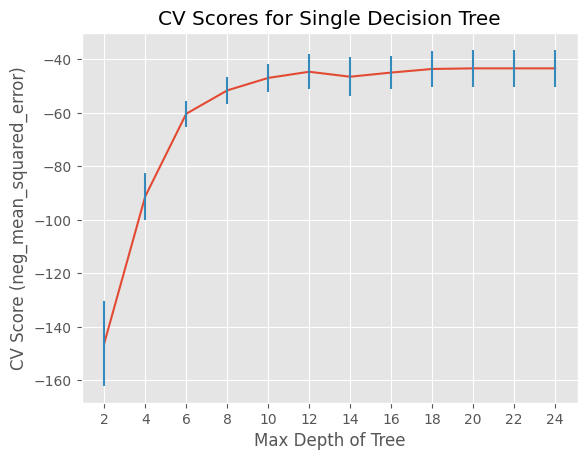

In [6]:
tree_cv_score = sns.lineplot(data = grid_cv_results, x = 'param_max_depth', y = 'mean_test_score')
tree_cv_score.set_xticks(params['max_depth'])
plt.errorbar(data = grid_cv_results, x='param_max_depth', y='mean_test_score', yerr='std_test_score', linestyle='')
plt.title('CV Scores for Single Decision Tree')
plt.ylabel('CV Score (neg_mean_squared_error)')
plt.xlabel('Max Depth of Tree')
plt.show()

In [7]:
final_tree = grid_cv.best_estimator_
final_tree.fit(X_train, y_train)

y_test_pred = final_tree.predict(X_test)
single_tree_test_mse = mean_squared_error(y_test, y_test_pred)
single_tree_cv_score = -1*cross_val_score(final_tree, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error").mean()

print(f'Single Tree Train CV Score (MSE): {single_tree_cv_score:.3f}')
print(f'Single Tree Test MSE: {single_tree_test_mse:.3f}')

Single Tree Train CV Score (MSE): 43.322
Single Tree Test MSE: 45.856


In [8]:
final_tree_performance = {'model': 'decision_tree', 
                          'params': final_tree.get_params(), 
                          'train_score_cv_mse': single_tree_cv_score, 
                          'test_score_mse': single_tree_test_mse}

field_names = final_tree_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_tree_performance)

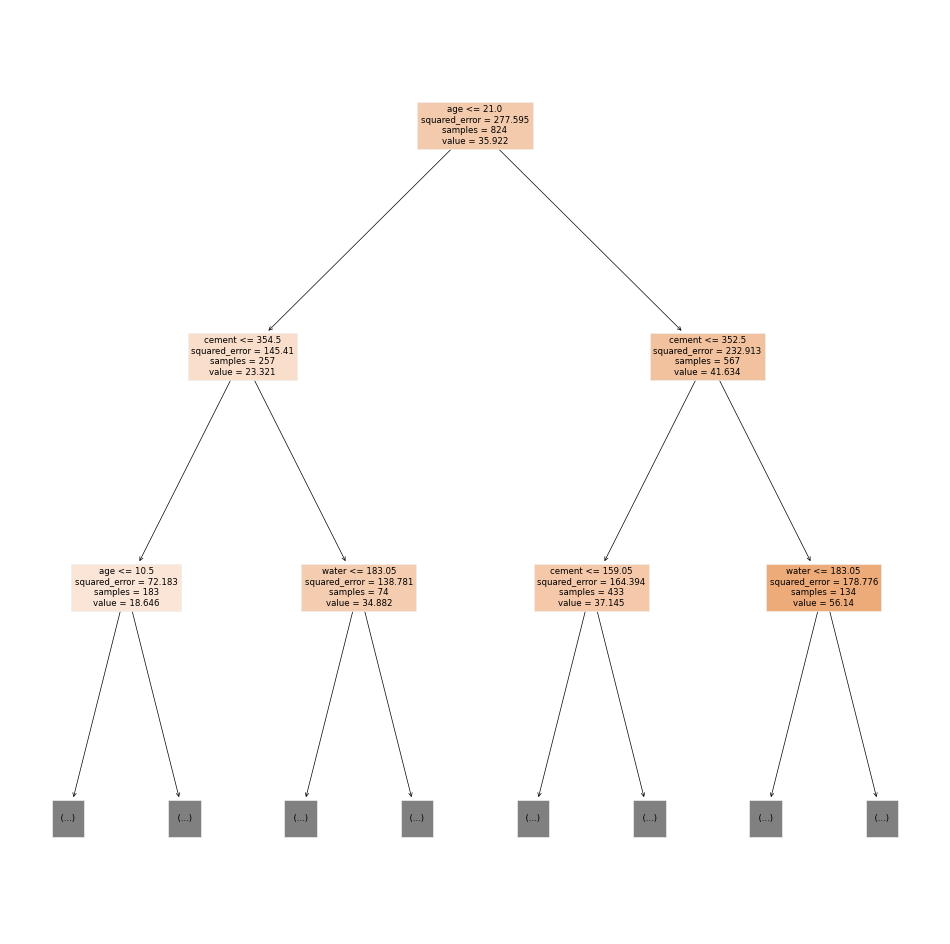

In [9]:
plt.figure(figsize=(12,12))
features = df.columns
plot_tree(final_tree, feature_names=features, filled=True, max_depth=2)
plt.show()

### Cost Complexity Pruning

In [10]:
path = final_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [11]:
trees = []

for alpha in ccp_alphas:
    subtree = DecisionTreeRegressor(max_depth = 20, random_state=0, ccp_alpha=alpha)
    subtree.fit(X_train, y_train)
    trees.append(subtree)

In [12]:
trees = trees[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [subtree.tree_.node_count for subtree in trees]
depth = [subtree.tree_.max_depth for subtree in trees]

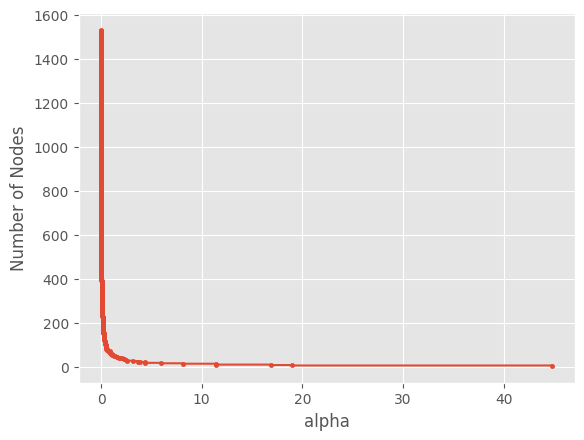

In [13]:
plt.scatter(ccp_alphas, node_counts, marker='.')
plt.plot(ccp_alphas, node_counts, drawstyle="steps-post")
plt.ylabel('Number of Nodes')
plt.xlabel('alpha')
plt.show()

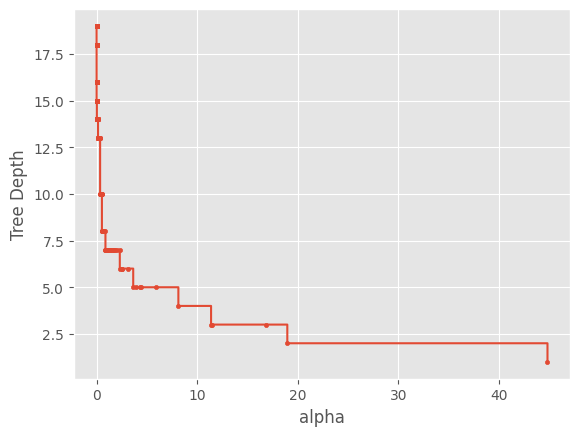

In [14]:
plt.scatter(ccp_alphas, depth, marker='.')
plt.plot(ccp_alphas, depth, drawstyle="steps-post")
plt.ylabel('Tree Depth')
plt.xlabel('alpha')
plt.show()

In [15]:
cv_mse = []
test_mse = []

for subtree in trees:
    cv_mse.append(-1*cross_val_score(subtree, X_train, y_train, scoring='neg_mean_squared_error', cv = 5).mean())
    y_test_pred = subtree.predict(X_test)
    test_mse.append(mean_squared_error(y_test, y_test_pred))

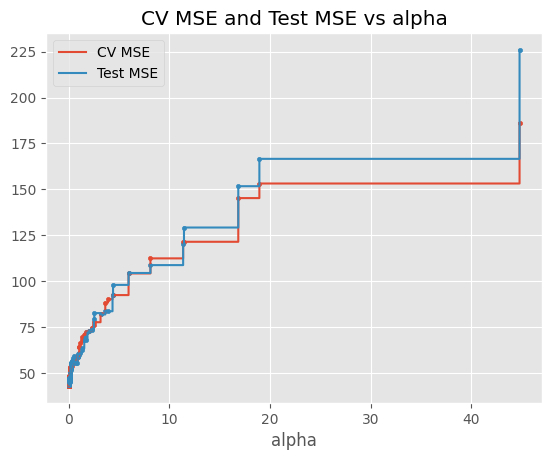

In [16]:
plt.scatter(ccp_alphas, cv_mse, marker='.')
plt.scatter(ccp_alphas, test_mse, marker='.')
plt.plot(ccp_alphas, cv_mse, label='CV MSE', drawstyle="steps-post")
plt.plot(ccp_alphas, test_mse, label='Test MSE', drawstyle="steps-post")
plt.xlabel('alpha')
plt.legend()
plt.title('CV MSE and Test MSE vs alpha')
plt.show()

---

## Random Forest Model

In [17]:
forest_baseline = RandomForestRegressor(random_state=0, oob_score=True)
cv_score_forest_baseline = cross_val_score(forest_baseline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
forest_baseline.fit(X_train, y_train)
baseline_forest_y_hat = forest_baseline.predict(X_test)
mse_forest_baseline = mean_squared_error(y_test, baseline_forest_y_hat)
oob_score_forest_baseline = forest_baseline.oob_score_

print(f'Baseline Random Forest Train CV Score (MSE): {cv_score_forest_baseline:.3f}')
print(f'Baseline Random Forest Test MSE: {mse_forest_baseline:.3f}')
print(f'Baseline Random Forest OOB Score (R-squared): {oob_score_forest_baseline:.4f}')

Baseline Random Forest Train CV Score (MSE): -28.860
Baseline Random Forest Test MSE: 29.076
Baseline Random Forest OOB Score (R-squared): 0.9141


In [18]:
forest = RandomForestRegressor(random_state=0, oob_score=True)
params = {'n_estimators': [5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
          'max_depth': range(6, 21, 2),
          'min_samples_split': [2, 5, 10],
          'max_features': range(1,5),
          'criterion': ['squared_error', 'absolute_error']
          }

grid_cv_tree = GridSearchCV(estimator=forest, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': range(6, 21, 2),
                         'max_features': range(1, 5),
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [5, 10, 25, 50, 100, 150, 200, 300,
                                          400, 500]},
             scoring='neg_mean_squared_error')

In [19]:
grid_cv_results_tree=pd.DataFrame(grid_cv_tree.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_tree[['param_criterion', 'param_max_depth', 
                     'param_max_features', 'param_min_samples_split', 'param_n_estimators', 
                     'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)

,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score
939,squared_error,20,4,2,500,-27.351751,4.497133,1
938,squared_error,20,4,2,400,-27.415849,4.566708,2
937,squared_error,20,4,2,300,-27.423515,4.618748,3
819,squared_error,18,4,2,500,-27.426438,4.424372,4
699,squared_error,16,4,2,500,-27.443184,4.383762,5
936,squared_error,20,4,2,200,-27.544606,4.589129,6
818,squared_error,18,4,2,400,-27.552044,4.498494,7
698,squared_error,16,4,2,400,-27.572822,4.531458,8
817,squared_error,18,4,2,300,-27.594679,4.513372,9
697,squared_error,16,4,2,300,-27.623944,4.491498,10


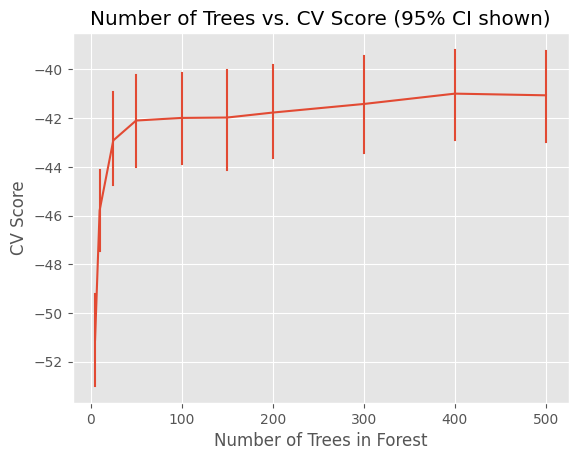

In [20]:
sns.lineplot(data=grid_cv_results_tree, x='param_n_estimators', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Number of Trees in Forest')
plt.title('Number of Trees vs. CV Score (95% CI shown)')
plt.show()

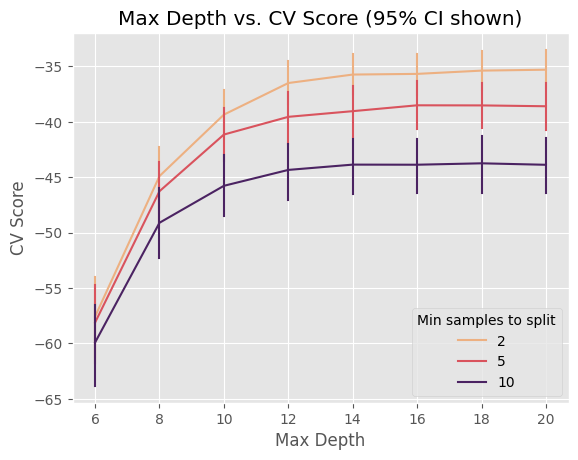

In [21]:
sns.lineplot(data=grid_cv_results_tree, x='param_max_depth', y='mean_test_score', hue='param_min_samples_split', err_style='bars', palette='flare')
plt.ylabel('CV Score')
plt.xlabel('Max Depth')
plt.title('Max Depth vs. CV Score (95% CI shown)')
plt.legend(title='Min samples to split')
plt.show()

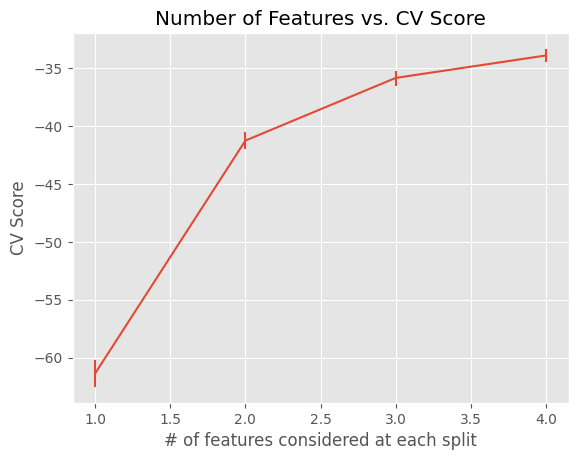

In [22]:
sns.lineplot(data=grid_cv_results_tree, x='param_max_features', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('# of features considered at each split')
plt.title('Number of Features vs. CV Score')
plt.show()

In [23]:
grid_cv_tree.best_params_

{'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 4,
 'min_samples_split': 2,
 'n_estimators': 500}

In [24]:
final_random_forest = grid_cv_tree.best_estimator_
final_random_forest.fit(X_train, y_train)
y_hat_forest = final_random_forest.predict(X_test)
mse_forest = mean_squared_error(y_test, y_hat_forest)
final_forest_oob_score = final_random_forest.oob_score_

print(f'Random Forest Train CV Score (MSE): {grid_cv_tree.best_score_:.3f}')
print(f'Random Forest Test MSE: {mse_forest:.3f}')
print(f'Random Forest OOB Score (R-Squared): {final_forest_oob_score:.4f}')

Random Forest Train CV Score (MSE): -27.352
Random Forest Test MSE: 27.255
Random Forest OOB Score (R-Squared): 0.9190


In [25]:
final_rf_performance = {'model': 'random_forest', 
                          'params': final_random_forest.get_params(), 
                          'train_score_cv_mse': -1*grid_cv_tree.best_score_, 
                          'test_score_mse': mse_forest}

field_names = final_rf_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_rf_performance)

---

## Gradient Boosted Trees

### Baseline GBM

In [26]:
gbm_baseline = GradientBoostingRegressor(random_state=0)
cv_score_gbm_baseline = cross_val_score(gbm_baseline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
gbm_baseline.fit(X_train, y_train)
gbm_baseline_mse = mean_squared_error(y_test, gbm_baseline.predict(X_test))

print(f'GBM Baseline CV Score: {cv_score_gbm_baseline}')
print(f'GBM Baseline Test MSE: {gbm_baseline_mse}')

GBM Baseline CV Score: -28.819010662003706
GBM Baseline Test MSE: 31.594039132243374


In [27]:
gbm_baseline.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [28]:
print('Baseline Feature Importances:\n')
for i,j in zip(gbm_baseline.feature_names_in_, gbm_baseline.feature_importances_):
    print(i, ': ', j)

Baseline Feature Importances:

cement :  0.2969461730299006
slag :  0.08047765964304146
flyash :  0.012741698717613522
water :  0.1023599378809138
superplasticizer :  0.07920050424254459
coarseaggregate :  0.01300243922707103
fineaggregate :  0.039882022257710155
age :  0.37538956500120485


### HyperParameter Tuning

In [29]:
gbm = GradientBoostingRegressor(random_state=0)

gbm_params = {'n_estimators': [25, 50, 75, 100, 200, 250, 500, 1000],
              'loss': ['squared_error', 'absolute_error'],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.8, 0.9, 1.0],
              'min_samples_split': [2,5,10],
              'max_depth': [2, 4, 8],
              'max_features': ['auto', 'sqrt']
              }

grid_cv_gbm = GridSearchCV(gbm, param_grid=gbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv_gbm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'loss': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 4, 8],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [25, 50, 75, 100, 200, 250, 500, 1000],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [30]:
grid_cv_results_gbm=pd.DataFrame(grid_cv_gbm.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_gbm[['param_n_estimators','param_loss','param_learning_rate','param_subsample',
                     'param_min_samples_split','param_max_depth','param_max_features',
                     'mean_test_score','std_test_score','rank_test_score']].head()

,param_n_estimators,param_loss,param_learning_rate,param_subsample,param_min_samples_split,param_max_depth,param_max_features,mean_test_score,std_test_score,rank_test_score
1151,1000,squared_error,0.05,1.0,10,4,sqrt,-19.844803,3.473226,1
2589,1000,absolute_error,0.1,0.8,10,8,sqrt,-20.307281,3.359068,2
1990,1000,squared_error,0.1,0.9,5,4,sqrt,-20.413385,4.725077,3
1988,500,squared_error,0.1,1.0,5,4,sqrt,-20.421401,4.875322,4
1102,1000,squared_error,0.05,0.9,2,4,sqrt,-20.440933,3.871759,5


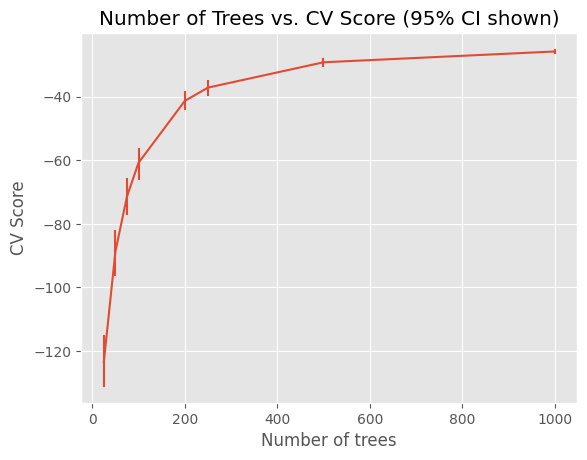

In [31]:
sns.lineplot(data=grid_cv_results_gbm, x='param_n_estimators', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Number of trees')
plt.title('Number of Trees vs. CV Score (95% CI shown)')
plt.show()

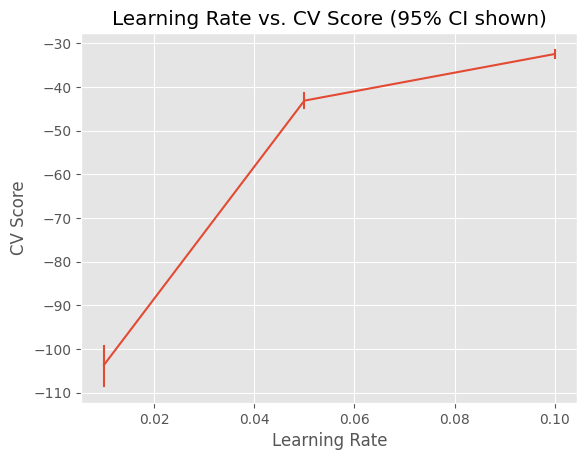

In [32]:
sns.lineplot(data=grid_cv_results_gbm, x='param_learning_rate', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Learning Rate')
plt.title('Learning Rate vs. CV Score (95% CI shown)')
plt.show()

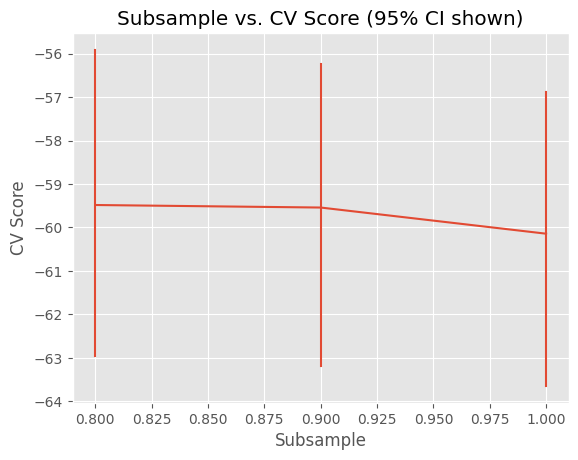

In [33]:
sns.lineplot(data=grid_cv_results_gbm, x='param_subsample', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Subsample')
plt.title('Subsample vs. CV Score (95% CI shown)')
plt.show()

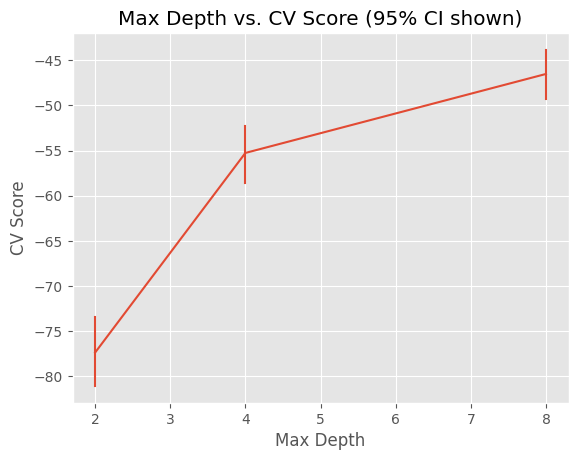

In [34]:
sns.lineplot(data=grid_cv_results_gbm, x='param_max_depth', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Max Depth')
plt.title('Max Depth vs. CV Score (95% CI shown)')
plt.show()

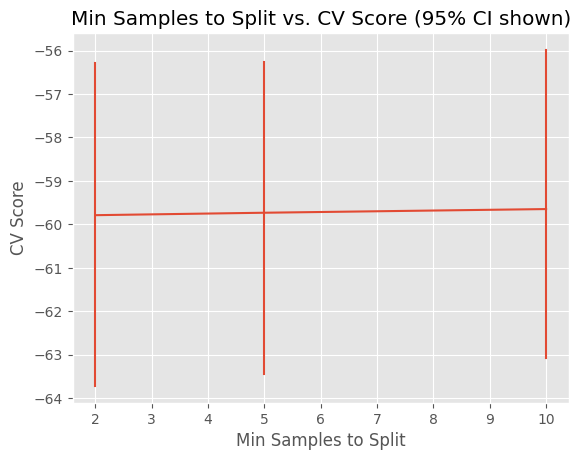

In [35]:
sns.lineplot(data=grid_cv_results_gbm, x='param_min_samples_split', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Min Samples to Split')
plt.title('Min Samples to Split vs. CV Score (95% CI shown)')
plt.show()

In [36]:
grid_cv_gbm.best_params_

{'learning_rate': 0.05,
 'loss': 'squared_error',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 1000,
 'subsample': 1.0}

In [37]:
final_gbm = grid_cv_gbm.best_estimator_
final_gbm.fit(X_train, y_train)
y_hat_gbm = final_gbm.predict(X_test)
mse_gbm = mean_squared_error(y_test, y_hat_gbm)

print(f'Boosted Tree Train CV Score (MSE): {grid_cv_gbm.best_score_:.3f}')
print(f'Boosted Tree Test MSE: {mse_gbm:.3f}')

Boosted Tree Train CV Score (MSE): -19.845
Boosted Tree Test MSE: 18.359


In [38]:
print('GBM Feature Importances:\n')
for i,j in zip(final_gbm.feature_names_in_, final_gbm.feature_importances_):
    print(i, ': ', j)

GBM Feature Importances:

cement :  0.20172504813632144
slag :  0.06252095251890073
flyash :  0.044657710540670977
water :  0.130725598647487
superplasticizer :  0.07525995291307375
coarseaggregate :  0.05863265287257195
fineaggregate :  0.06092694616920305
age :  0.36555113820177115


In [39]:
final_gbm_performance = {'model': 'gradient_boosted_tree', 
                          'params': final_gbm.get_params(), 
                          'train_score_cv_mse': -1*grid_cv_gbm.best_score_, 
                          'test_score_mse': mse_gbm}

field_names = final_gbm_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_gbm_performance)

---

## Light Gradient Boosted Trees (LGBM)

### Baseline LGBM

In [40]:
lgbm_baseline = LGBMRegressor(random_state=0)
cv_score_lgbm_baseline = cross_val_score(lgbm_baseline, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
lgbm_baseline.fit(X_train, y_train)
lgbm_baseline_mse = mean_squared_error(y_test, lgbm_baseline.predict(X_test))

print(f'LGBM Baseline CV Score: {cv_score_lgbm_baseline:.3f}')
print(f'LGBM Baseline Test MSE: {lgbm_baseline_mse:.3f}')

LGBM Baseline CV Score: -23.566
LGBM Baseline Test MSE: 24.327


In [41]:
lgbm_baseline.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [42]:
print('Baseline Feature Importances:\n')
for i,j in zip(lgbm_baseline.feature_name_, lgbm_baseline.feature_importances_):
    print(i, ': ', j)

Baseline Feature Importances:

cement :  547
slag :  316
flyash :  134
water :  446
superplasticizer :  339
coarseaggregate :  466
fineaggregate :  415
age :  322


### HyperParameter Tuning

In [43]:
lgbm = LGBMRegressor(random_state=0)

lgbm_params = {'boosting_type': ['gbdt'],
              'n_estimators': [25, 50, 75, 100, 200, 250, 500, 1000],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.8, 0.9, 1.0],
              'min_child_samples': [2, 4, 16],
              'max_depth': [2, 4, 8],
              'colsample_bytree': [0.25, 0.5, 1.0]
              }

grid_cv_lgbm = GridSearchCV(lgbm, param_grid=lgbm_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_cv_lgbm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=0), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.25, 0.5, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 4, 8],
                         'min_child_samples': [2, 4, 16],
                         'n_estimators': [25, 50, 75, 100, 200, 250, 500, 1000],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [44]:
grid_cv_results_lgbm=pd.DataFrame(grid_cv_lgbm.cv_results_).sort_values('mean_test_score', ascending=False)
grid_cv_results_lgbm[['param_boosting_type', 'param_n_estimators', 'param_learning_rate',
              'param_subsample', 'param_min_child_samples', 'param_max_depth',
              'param_colsample_bytree', 'mean_test_score', 'std_test_score', 'rank_test_score']].head()

,param_boosting_type,param_n_estimators,param_learning_rate,param_subsample,param_min_child_samples,param_max_depth,param_colsample_bytree,mean_test_score,std_test_score,rank_test_score
1937,gbdt,250,0.1,1.0,16,8,1.0,-21.815849,2.989992,1
1936,gbdt,250,0.1,0.9,16,8,1.0,-21.815849,2.989992,1
1935,gbdt,250,0.1,0.8,16,8,1.0,-21.815849,2.989992,1
1940,gbdt,500,0.1,1.0,16,8,1.0,-21.877091,2.914286,4
1939,gbdt,500,0.1,0.9,16,8,1.0,-21.877091,2.914286,4


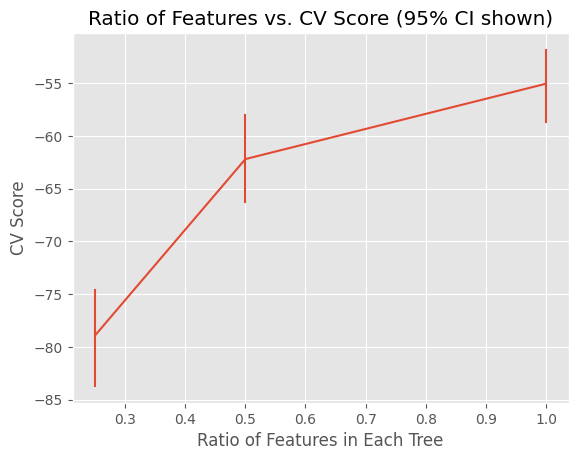

In [45]:
sns.lineplot(data=grid_cv_results_lgbm, x='param_colsample_bytree', y='mean_test_score', err_style='bars')
plt.ylabel('CV Score')
plt.xlabel('Ratio of Features in Each Tree')
plt.title('Ratio of Features vs. CV Score (95% CI shown)')
plt.show()

In [46]:
grid_cv_lgbm.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_samples': 16,
 'n_estimators': 250,
 'subsample': 0.8}

In [47]:
final_lgbm = grid_cv_lgbm.best_estimator_
final_lgbm.fit(X_train, y_train)
y_hat_lgbm = final_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_hat_lgbm)

print(f'Light Boosted Tree Train CV Score (MSE): {grid_cv_lgbm.best_score_:.3f}')
print(f'Light Boosted Tree Test MSE: {mse_lgbm:.3f}')

Light Boosted Tree Train CV Score (MSE): -21.816
Light Boosted Tree Test MSE: 21.867


In [48]:
print('LGBM Feature Importances:\n')
for i,j in zip(final_lgbm.feature_name_, final_lgbm.feature_importances_):
    print(i, ': ', j)

LGBM Feature Importances:

cement :  963
slag :  500
flyash :  290
water :  714
superplasticizer :  479
coarseaggregate :  873
fineaggregate :  784
age :  558


In [49]:
final_lgbm_performance = {'model': 'light_gradient_boosted_tree', 
                          'params': final_lgbm.get_params(), 
                          'train_score_cv_mse': -1*grid_cv_lgbm.best_score_, 
                          'test_score_mse': mse_lgbm}

field_names = final_lgbm_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_lgbm_performance)

---

## Bayesian Additive Regression Tree (BART)

In [50]:
bart_baseline = BartModel(n_samples=1000, n_burn=0, n_chains=1, n_trees=200, thin=1, store_in_sample_predictions=True)
cv_score_bart_baseline = cross_val_score(bart_baseline, X_train, np.array(y_train), cv=5, scoring='neg_mean_squared_error').mean()
bart_baseline.fit(X_train, np.array(y_train))
bart_baseline_mse = mean_squared_error(y_test, bart_baseline.predict(X_test))

print(f'BART Baseline CV Score: {cv_score_bart_baseline:.3f}')
print(f'BART Baseline Test MSE: {bart_baseline_mse:.3f}')

BART Baseline CV Score: -34.865
BART Baseline Test MSE: 36.197


In [51]:
sample_pred_baseline_norm = bart_baseline._prediction_samples
sample_pred_baseline = (sample_pred_baseline_norm + 0.5)*(np.max(y_train)-np.min(y_train))+np.min(y_train)

In [52]:
scores_baseline = []
for pred in sample_pred_baseline:
    scores_baseline.append(mean_squared_error(y_train, pred))

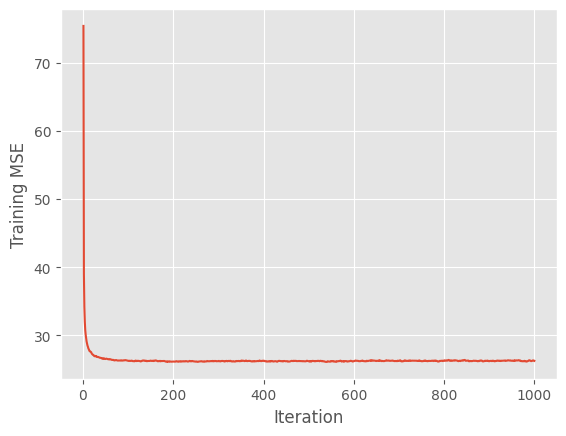

In [53]:
sns.lineplot(x=range(1,1001), y = scores_baseline)
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.show()

In [54]:
final_bart = BartModel(n_samples=1000, n_burn=200, n_chains=1, n_trees=200, thin=1, store_in_sample_predictions=True)
cv_score_final_bart = cross_val_score(final_bart, X_train, np.array(y_train), cv=5, scoring='neg_mean_squared_error').mean()
final_bart.fit(X_train, np.array(y_train))
mse_bart = mean_squared_error(y_test, final_bart.predict(X_test))

print(f'Final BART CV Score: {-1*cv_score_final_bart:.3f}')
print(f'Final BART Test MSE: {mse_bart:.3f}')

Final BART CV Score: 35.333
Final BART Test MSE: 34.902


In [55]:
final_bart_performance = {'model': 'bayesian_additive_regression_tree', 
                          'params': final_bart.get_params(), 
                          'train_score_cv_mse': -1*cv_score_final_bart, 
                          'test_score_mse': mse_bart}

field_names = final_bart_performance.keys()

with open('../data/models.csv', 'a') as file:
    writer = DictWriter(file, fieldnames=field_names)
    writer.writerow(final_bart_performance)